In [ ]:
import numpy as np
import math
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import operator

from time import perf_counter
import scipy.stats

# Test the SBPS algorithm: the component analytic_Bi_adaptive_thinning

# Test my algorithm: analytic_bisection code

Let's cut out the part of analytic_Bi_adaptive_thinning that simulates the NHPP with the upper-bound intensity, to form the following function analytic_bisection_NHPP_simulation. There is a few difference between the 2 functions, but the way they use to simulate event times are essentially the same.

Concerning the arguments of analytic_bisection_NHPP_simulation:
1. hat_beta_0, hat_beta_1, Sigma_cov_mat, k represents the intensity function of the Poisson Process: hat_beta_0 + hat_beta_1*t + k*np.sqrt((1,t)^T Sigma_cov_mat (1,t)).

2. t_geom represents the time period we want to simulate the NHPP: [0,t_geom].

3. num_bisections represents the number of bisections performed in bisection method.

4. array_of_intensities is a 1D array np.array([-log(V_1), ..., -log(V_m)]). For each -log(V_i), we want to find the event time corresponding to the probabilities -log(V_i) of no arrival until that time.


For simplicity, I require that 0 < -log(V_1) < ... < -log(V_m). And -log(V_1), ..., -log(V_m) are individual intensities and have nothing to do with each other.

# Function: analytic_bisection_NHPP_simulation

In [ ]:
# let's cut out the part of analytic_Bi_adaptive_thinning that simulates the NHPP with
# the upper-bound intensity.


def analytic_bisection_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, k, 
                                       array_of_intensities, num_bisections = 17):
  
  start_time = perf_counter()

#  num_evals_ADAPTIVE = 0

  # Step 0: define the Rho function
  Rho = lambda t: hat_beta_0 + hat_beta_1*t + k*np.sqrt(Sigma_cov_mat[0,0] + 2*Sigma_cov_mat[0,1]*t 
                                                        + Sigma_cov_mat[1,1]*(t**2))
  Lambda = lambda t: max(0, Rho(t))



  # Step 1: find all global time t such that Rho(t)=0. There is an exception
  #         when A=0, B=0, C=0.
  A, B, C, candidates = quadratic_equation_candidates_only(hat_beta_0, hat_beta_1, Sigma_cov_mat, k)
  print('candidate ')
  
  






  # Step 2: Lambda = max(0, Rho). We need to determine the sign of Rho in different regions of [0,t_geom],
  #         by picking a point (the variable test_point below) and evaluate Rho on it.
#  t_geom = d_geom/np.linalg.norm(v)

  if candidates == 'no_candidates':
    boundaries_and_zeroes = [0, t_geom]
  else:
    filter_candidates = [x for x in candidates if (0 < x) and (x < t_geom) 
                         and (hat_beta_0 + hat_beta_1*x <= 0)]
    # debugging:
    print('filter_candidates: {}'.format(filter_candidates))
    boundaries_and_zeroes = [0] + filter_candidates + [t_geom]
  
  # debugging:
  print('boundaries_and_zeroes: {}'.format(boundaries_and_zeroes))

  
  B_and_Z_length = len(boundaries_and_zeroes)
  
  # 1 means that the region has a positive sign of Rho. 0 means otherwise.
  signs_of_regions = []

  for i in range(B_and_Z_length - 1):
    test_point = 0.5*(boundaries_and_zeroes[i] + boundaries_and_zeroes[i+1])

    if Rho(test_point) > 0:
      signs_of_regions.append(1)
    else:
      signs_of_regions.append(0)
  
  # debugging:
  print('signs_of_regions: {}'.format(signs_of_regions))



  # Step 3: Note that Rho can be integrated analytically. Hence, We need to construct an 
  # anti-derivative for it.
  a = Sigma_cov_mat[1,1]
  b = Sigma_cov_mat[0,0] - (Sigma_cov_mat[0,1]**2)/Sigma_cov_mat[1,1]
  c = Sigma_cov_mat[0,1]/Sigma_cov_mat[1,1]

  complicated_1 = lambda t: (t + c)*np.sqrt(a*((t + c)**2) + b)
  complicated_2 = lambda t: (b/np.sqrt(a))*np.log(np.sqrt(a)*np.sqrt(a*((t + c)**2) + b) + a*(t + c))  if (not b == 0)   else 0

  Anti_derivative = lambda t: hat_beta_0*t + 0.5*hat_beta_1*(t**2) +\
  0.5*k*(complicated_1(t) + complicated_2(t))



  # Step 4: compute intensity in each region.
  intensities_of_individual_regions = []
  cumulative_intensities_of_each_region = [0]
  
  for i in range(B_and_Z_length - 1):
    if signs_of_regions[i] == 0:
      intensities_of_individual_regions.append(0)
      
      cumulative_intensities_of_each_region.append(cumulative_intensities_of_each_region[-1])

    if signs_of_regions[i] == 1:
      regional_intensity = (Anti_derivative(boundaries_and_zeroes[i+1]) - 
                            Anti_derivative(boundaries_and_zeroes[i]))
      
      intensities_of_individual_regions.append(regional_intensity)
      cumulative_intensities_of_each_region.append(cumulative_intensities_of_each_region[-1] + 
                                                   regional_intensity)

  cumulative_intensities_of_each_region = cumulative_intensities_of_each_region[1:]

  # debugging
  print('intensities_of_individual_regions: {}'.format(intensities_of_individual_regions))
  print('cumulative_intensities_of_each_region: {}'.format(cumulative_intensities_of_each_region))



  # Step 5: Simulate the first arrival of the Cox Process via adaptive thinning on [0, t_geom].
  #         Note that it is possible that our upper-bound NHPP (or our Cox Process) has no 
  #         arrivals at all.


  # We are going to simulate events of our upper-bound NHPP in [0, t_geom] until having an acceptance,
  # or until that the whole period [0, t_geom] has been simulated. We will accumulate the 'rejected' 
  # inverse-transform intensities in this variable.
  
  list_of_proposal_event_times = []


  for required_intensity in array_of_intensities:
    i_event_time_found = 0
    ith_region = 0

    if required_intensity == 0:
      list_of_proposal_event_times.append(0)

    else:

      while i_event_time_found == 0 and (not ith_region > len(cumulative_intensities_of_each_region) - 1):
      
        if required_intensity == cumulative_intensities_of_each_region[ith_region]:
          proposal_event_time = boundaries_and_zeroes[ith_region+1]
          i_event_time_found = 1
          list_of_proposal_event_times.append(proposal_event_time)


        elif required_intensity < cumulative_intensities_of_each_region[ith_region]:
          if ith_region == 0:
            remaining_intensity = required_intensity

          elif ith_region > 0:
            remaining_intensity = required_intensity - cumulative_intensities_of_each_region[ith_region - 1]

          # We consider the following function to have the following interval domain:
          # [current_region_lower_bound, current_region_upper_bound]
          twisted_integral = lambda t: Anti_derivative(t) - Anti_derivative(boundaries_and_zeroes[ith_region])\
          - remaining_intensity
    
          proposal_event_time = Bisection_Method_strict_increase(twisted_integral, boundaries_and_zeroes[ith_region], 
                                                               boundaries_and_zeroes[ith_region+1], num_bisections)
        
          i_event_time_found = 1
          list_of_proposal_event_times.append(proposal_event_time)
      
        ith_region = ith_region + 1
    
      if i_event_time_found == 0:
        list_of_proposal_event_times.append('no_event_time')
  

  computational_time = perf_counter() - start_time


  return list_of_proposal_event_times, computational_time


  
  

# Function: linear_interpolation_NHPP_simulation

The following is a function that simulates the upper-bound NHPP with linear interpolation. We will run both analytic_bisection_NHPP_simulation and linear_interpolation_NHPP_simulation. The 2 algorithm should produce the same results on the same array_of_intensities.

Moreover, we also want to compare the computational speed of the 2 algorithms.

In [ ]:
# I assume that t_geom/step_size to be positive integer.

def linear_interpolation_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, k, 
                                         array_of_intensities, step_size):
  
  start_time = perf_counter()
  
  # Step 0: define the Rho and Lambda functions
  Rho = lambda t: hat_beta_0 + hat_beta_1*t + k*np.sqrt(Sigma_cov_mat[0,0] + 2*Sigma_cov_mat[0,1]*t 
                                                        + Sigma_cov_mat[1,1]*(t**2))
  Lambda = lambda t: max(0, Rho(t))

  
  discretised_time = np.arange(0,t_geom + step_size*0.5, step_size)
  intensities = np.array([Lambda(x) for x in discretised_time])

  trapeziums_areas = (intensities[:-1] + intensities[1:])*step_size*0.5


  num_increments = t_geom/step_size

  # debugging
  if not len(trapeziums_areas) == t_geom/step_size:
    print('Actual length of trapeziums_areas is: {}'.format(len(trapeziums_areas)))
    print('But theoretically it should be: {}'.format(t_geom/step_size))



  accumulated_trapeziums_areas = [np.sum(trapeziums_areas[:i]) for i in range(1,int(num_increments + 1))]


  list_of_proposal_event_times = []

  for required_intensity in array_of_intensities:
    
    indications = np.where(accumulated_trapeziums_areas < required_intensity, 1, 0)
    event_time = np.sum(indications)*step_size

    # Technicality regarding that the event occurs outside of the period [0,t_geom] of our NHPP.
    if event_time == t_geom:
      if required_intensity > accumulated_trapeziums_areas[-1]:
        event_time = 'no_event_time'

    list_of_proposal_event_times.append(event_time)
  

  computational_time = perf_counter() - start_time


  return list_of_proposal_event_times, computational_time








# First Set of value for testing:

Setting the following values of hat_beta_0, hat_beta_1, Sigma_cov_mat, k should produce an intensity function with 2 roots in [0,10].

In [ ]:
hat_beta_0 = 0
hat_beta_1 = -1
Sigma_cov_mat = np.array([[9.1, -3],[-3, 1]])
k = 3

t_geom = 10
step_size = 0.01

array_of_intensities = np.arange(0,45.1,5)

num_bisections = 17

In [ ]:
# Using my quadratic equation solver solutions, and plotting the 2 elements in sols. It shows that
# my function quadratic_equation_candidates_only is finding the correct roots of Rho.

A, B, C, sols = quadratic_equation_candidates_only(hat_beta_0, hat_beta_1, Sigma_cov_mat, k)

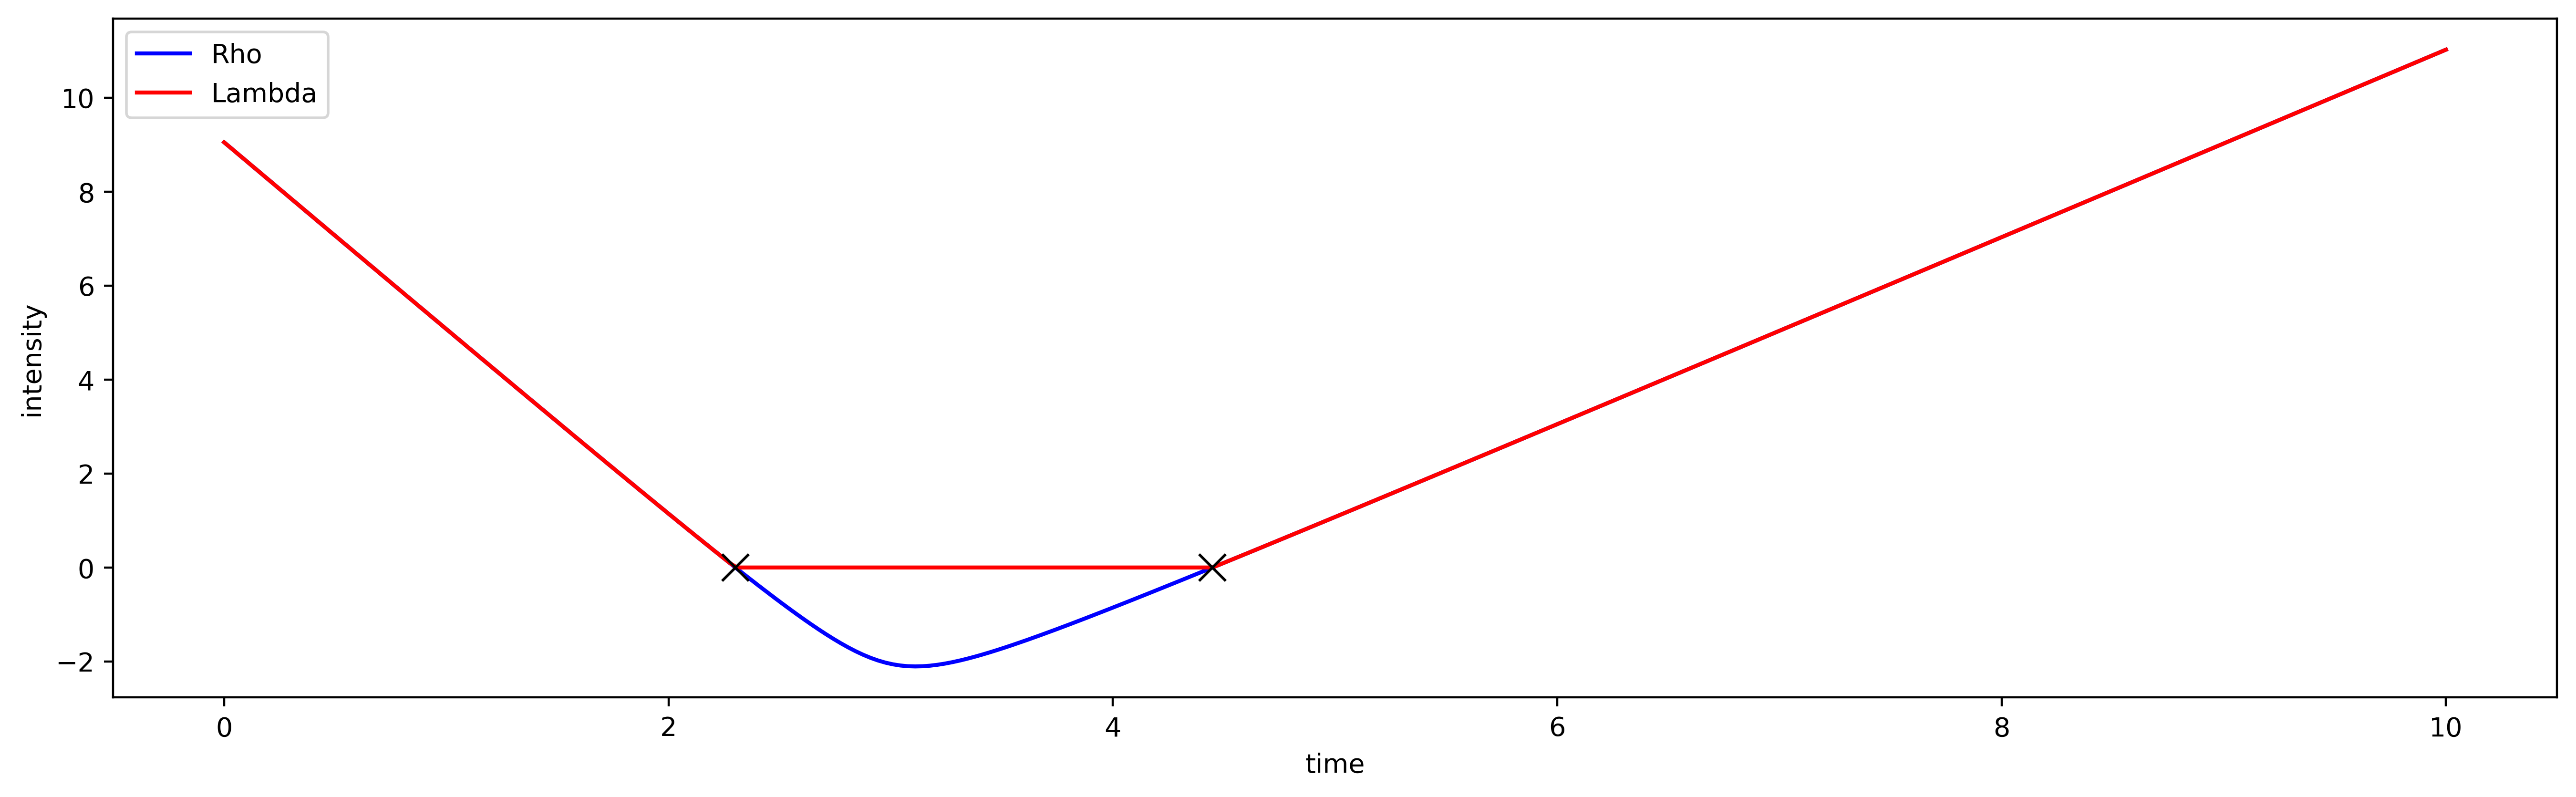

In [ ]:
# visualise Rho and Lambda

Rho = lambda t: hat_beta_0 + hat_beta_1*t + k*np.sqrt(Sigma_cov_mat[0,0] + 2*Sigma_cov_mat[0,1]*t 
                                                      + Sigma_cov_mat[1,1]*(t**2))
Lambda = lambda t: max(0,Rho(t))



x_vals = np.linspace(0,10,300)
y_vals_Rho = np.array([Rho(x) for x in x_vals])
y_vals_Lambda = np.array([Lambda(x) for x in x_vals])

plt.figure(num='test_1', figsize=[16.53, 4.71], dpi=400)

plt.xlabel('time')
plt.ylabel('intensity')

plt.plot(x_vals, y_vals_Rho, color='blue', label='Rho', zorder = 1)
plt.plot(x_vals, y_vals_Lambda, color='red', label='Lambda', zorder = 2)
plt.plot([sols[0]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)
plt.plot([sols[1]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)


plt.legend()

plt.show()

In [ ]:
# Analytic-Bisection

AnaBi_event_times, AnaBi_cpu_sec =\
analytic_bisection_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                   k, array_of_intensities, num_bisections)

candidate 
filter_candidates: [2.301163420254273, 4.448836579745727]
boundaries_and_zeroes: [0, 2.301163420254273, 4.448836579745727, 10]
signs_of_regions: [1, 0, 1]
intensities_of_individual_regions: [10.334857054547694, 0, 30.482810145028076]
cumulative_intensities_of_each_region: [10.334857054547694, 10.334857054547694, 40.817667199575766]


In [ ]:
# Linear Interpolation
linear_event_times, linear_cpu_sec =\
linear_interpolation_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                     k, array_of_intensities, step_size)

In [ ]:
print(AnaBi_event_times)
print(AnaBi_cpu_sec)

[0, 0.6435943545638372, 1.881414231768942, 6.628546603004063, 7.581551663448413, 8.30445822183098, 8.911066144715363, 9.44415096810053, 9.92531222006517, 'no_event_time']
0.00928257900159224


In [ ]:
print(linear_event_times)
print(linear_cpu_sec)

[0.0, 0.64, 1.8800000000000001, 6.62, 7.58, 8.3, 8.91, 9.44, 9.92, 'no_event_time']
0.01935034100097255


# Second Set of value for testing:

In [ ]:
hat_beta_0 = -20
hat_beta_1 = 5
Sigma_cov_mat = np.array([[32.1, -8],[-8, 2]])
k = 2*np.sqrt(2)

t_geom = 10
step_size = 0.0001

array_of_intensities = np.arange(0,180.1,10)

num_bisections = 17

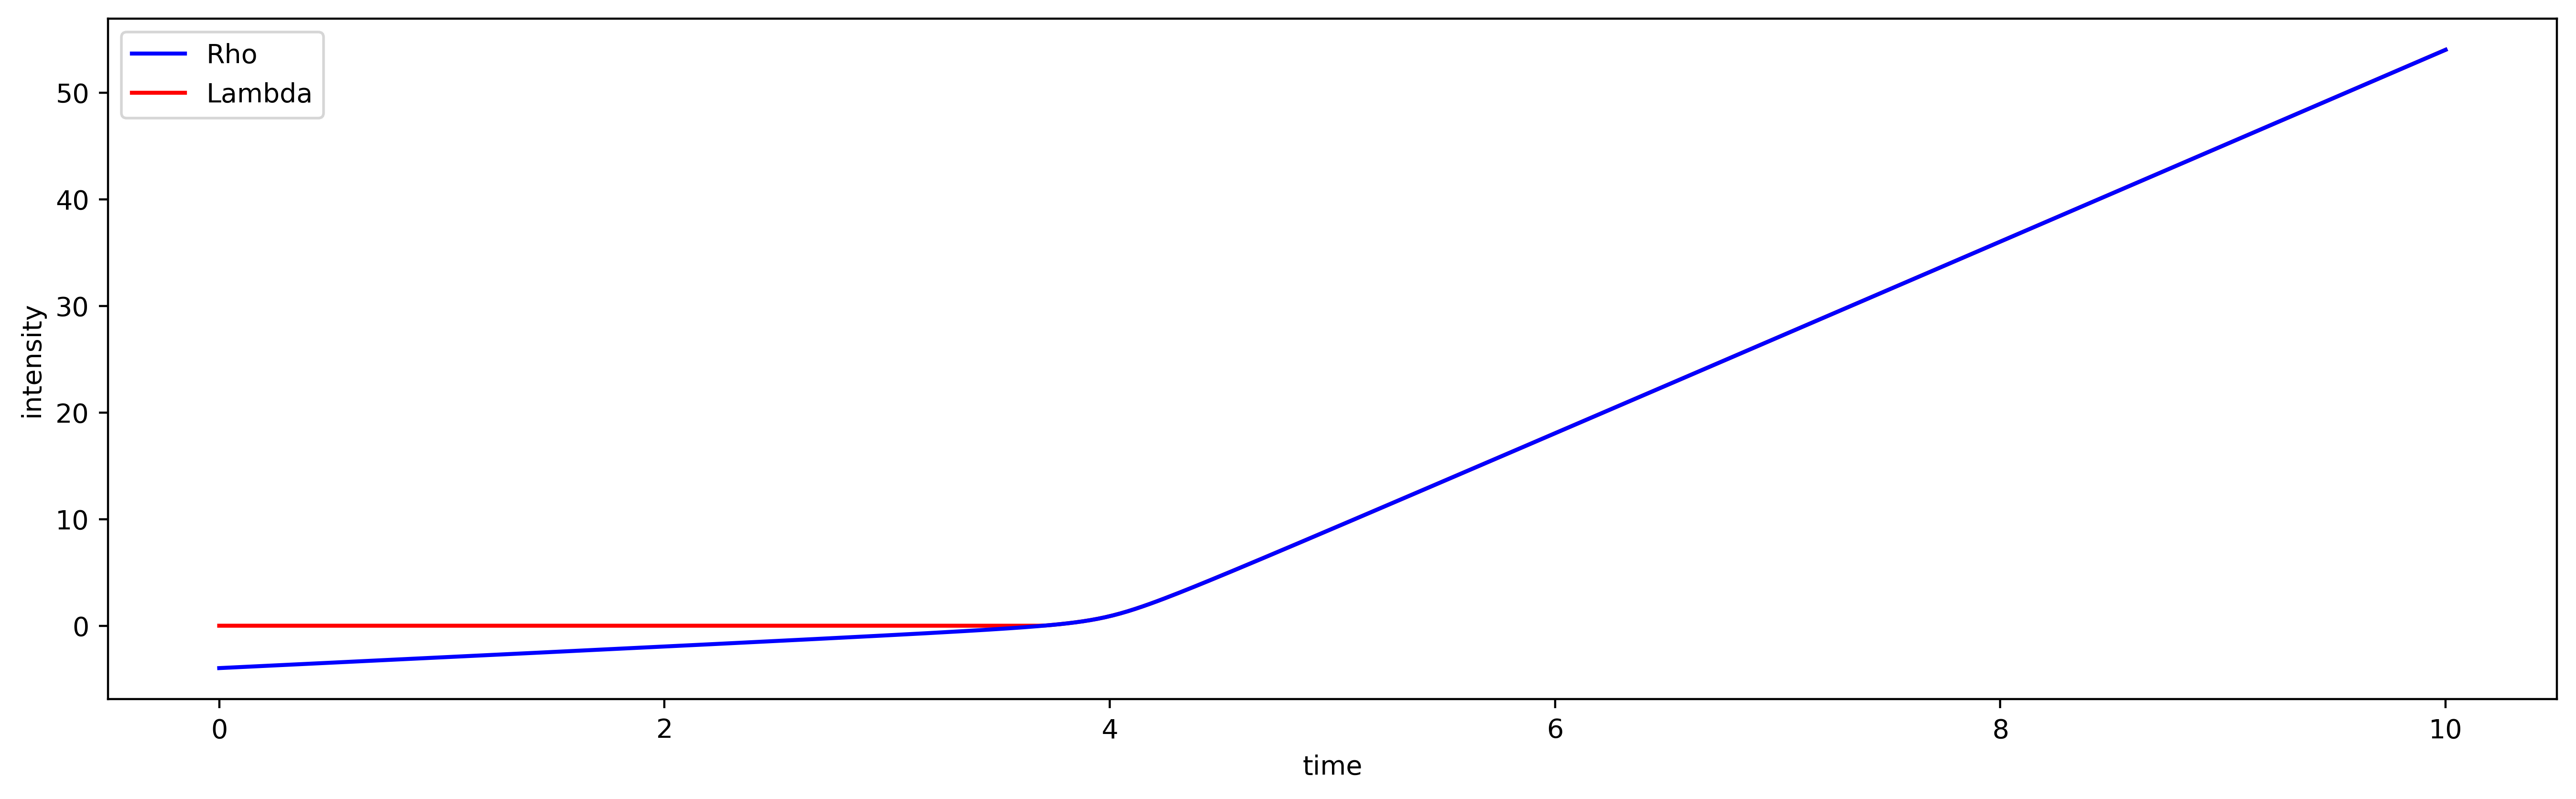

In [ ]:
# visualise Rho and Lambda

Rho = lambda t: hat_beta_0 + hat_beta_1*t + k*np.sqrt(Sigma_cov_mat[0,0] + 2*Sigma_cov_mat[0,1]*t 
                                                      + Sigma_cov_mat[1,1]*(t**2))
Lambda = lambda t: max(0,Rho(t))


x_vals = np.linspace(0,10,300)
y_vals_Rho = np.array([Rho(x) for x in x_vals])
y_vals_Lambda = np.array([Lambda(x) for x in x_vals])

plt.figure(num='test_2', figsize=[16.53, 4.71], dpi=400)

plt.xlabel('time')
plt.ylabel('intensity')

plt.plot(x_vals, y_vals_Rho, color='blue', label='Rho', zorder = 2)
plt.plot(x_vals, y_vals_Lambda, color='red', label='Lambda', zorder = 1)
# plt.plot([sols[0]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)
# plt.plot([sols[1]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)


plt.legend()

plt.show()

In [ ]:
quadratic_equation_candidates_only(hat_beta_0, hat_beta_1, Sigma_cov_mat, k)

(-8.999999999999996,
 71.99999999999997,
 -143.19999999999993,
 [3.7018576030000223])

In [ ]:
# Analytic-Bisection

AnaBi_event_times, AnaBi_cpu_sec =\
analytic_bisection_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                   k, array_of_intensities, num_bisections)

candidate 
filter_candidates: [3.7018576030000223]
boundaries_and_zeroes: [0, 3.7018576030000223, 10]
signs_of_regions: [0, 1]
intensities_of_individual_regions: [0, 162.55815586260974]
cumulative_intensities_of_each_region: [0, 162.55815586260974]


In [ ]:
# Linear Interpolation
linear_event_times, linear_cpu_sec =\
linear_interpolation_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                     k, array_of_intensities, step_size)

In [ ]:
AnaBi_event_times

[0,
 5.459299383846242,
 6.084202810001216,
 6.561541574739662,
 6.963199993749999,
 7.3166632465601475,
 7.636010280026197,
 7.929505868411784,
 8.202579776204072,
 8.458979982429597,
 8.701445394838519,
 8.931994155983581,
 9.152260000312257,
 9.363540305179875,
 9.566748039836497,
 9.762844224545336,
 9.95245352247748,
 'no_event_time',
 'no_event_time']

In [ ]:
print(AnaBi_cpu_sec)

0.017470754999521887


In [ ]:
linear_event_times

[0.0,
 5.4592,
 6.0841,
 6.5615000000000006,
 6.963100000000001,
 7.3166,
 7.6359,
 7.9294,
 8.2025,
 8.4589,
 8.7014,
 8.932,
 9.1522,
 9.3635,
 9.5667,
 9.7628,
 9.9524,
 'no_event_time',
 'no_event_time']

In [ ]:
print(linear_cpu_sec)

2.941039722001733


In [ ]:
# The difference of the result computed using analytic-bisection and linear interpolation is very small.

np.array(AnaBi_event_times[:-2]) - np.array(linear_event_times[:-2])

array([ 0.00000000e+00,  9.93838462e-05,  1.02810001e-04,  4.15747397e-05,
        9.99937500e-05,  6.32465601e-05,  1.10280026e-04,  1.05868412e-04,
        7.97762041e-05,  7.99824296e-05,  4.53948385e-05, -5.84401642e-06,
        6.00003123e-05,  4.03051799e-05,  4.80398365e-05,  4.42245453e-05,
        5.35224775e-05])

# Third Set of value for testing (degenerate case)

In [ ]:
hat_beta_0 = -15
hat_beta_1 = 3
Sigma_cov_mat = np.array([[75, -15],[-15, 3]])
k = np.sqrt(3)

t_geom = 10
step_size = 0.0001

array_of_intensities = np.arange(0,100.1,10)

num_bisections = 17

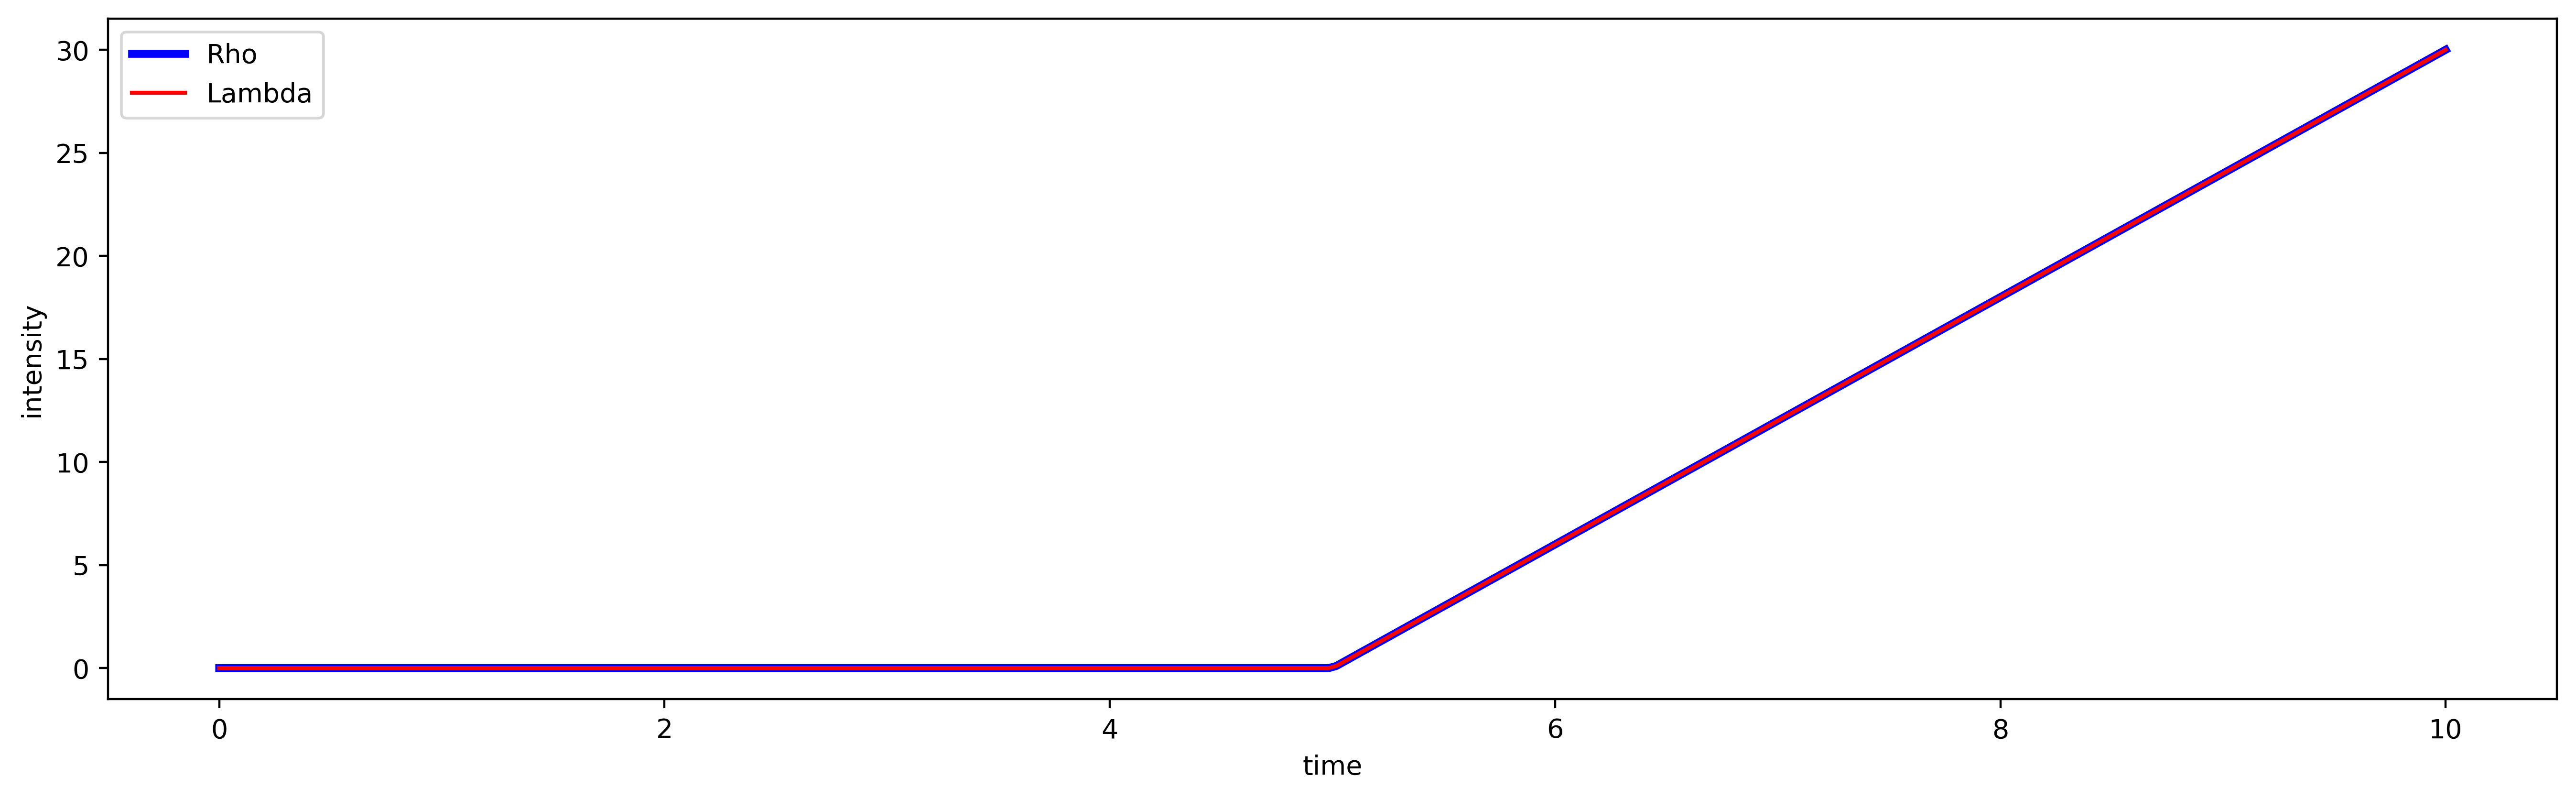

In [ ]:
# visualise Rho and Lambda

Rho = lambda t: hat_beta_0 + hat_beta_1*t + k*np.sqrt(Sigma_cov_mat[0,0] + 2*Sigma_cov_mat[0,1]*t 
                                                      + Sigma_cov_mat[1,1]*(t**2))
Lambda = lambda t: max(0,Rho(t))


x_vals = np.linspace(0,10,300)
y_vals_Rho = np.array([Rho(x) for x in x_vals])
y_vals_Lambda = np.array([Lambda(x) for x in x_vals])

plt.figure(num='test_3', figsize=[16.53, 4.71], dpi=400)

plt.xlabel('time')
plt.ylabel('intensity')

plt.plot(x_vals, y_vals_Rho, color='blue', label='Rho', zorder = 1, linewidth = 3)
plt.plot(x_vals, y_vals_Lambda, color='red', label='Lambda', zorder = 2, linewidth = 1.5)
# plt.plot([sols[0]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)
# plt.plot([sols[1]], [0], color = 'black', marker = 'x', markersize = 10, zorder = 3)


plt.legend()

plt.show()

In [ ]:
quadratic_equation_candidates_only(hat_beta_0, hat_beta_1, Sigma_cov_mat, k)

1


(0, 0, 0, [5.0])

In [ ]:
# Analytic-Bisection

AnaBi_event_times, AnaBi_cpu_sec =\
analytic_bisection_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                   k, array_of_intensities, num_bisections)

1
candidate 
filter_candidates: [5.0]
boundaries_and_zeroes: [0, 5.0, 10]
signs_of_regions: [0, 1]
intensities_of_individual_regions: [0, 75.0]
cumulative_intensities_of_each_region: [0, 75.0]


In [ ]:
# Linear Interpolation
linear_event_times, linear_cpu_sec =\
linear_interpolation_NHPP_simulation(t_geom, hat_beta_0, hat_beta_1, Sigma_cov_mat, 
                                     k, array_of_intensities, step_size)

In [ ]:
print(AnaBi_event_times)
print(AnaBi_cpu_sec)

[0, 6.825733184814453, 7.581996917724609, 8.162288665771484, 8.651485443115234, 9.082469940185547, 9.47214126586914, 9.830455780029297, 'no_event_time', 'no_event_time', 'no_event_time']
0.004784573000051751


In [ ]:
print(linear_event_times)
print(linear_cpu_sec)

[0.0, 6.8257, 7.5819, 8.1622, 8.6514, 9.0824, 9.472100000000001, 9.830400000000001, 'no_event_time', 'no_event_time', 'no_event_time']
3.5493884350000258


In [ ]:
# difference between linear_event_times and AnaBi_event_times

np.array(linear_event_times[:-3]) - np.array(AnaBi_event_times[:-3])

array([ 0.00000000e+00, -3.31848145e-05, -9.69177246e-05, -8.86657715e-05,
       -8.54431152e-05, -6.99401855e-05, -4.12658691e-05, -5.57800293e-05])